# Model Optimisation in Algorithm Trading and Key Signals Search

This project could be divided into two parts: first part concentrate on training models for price prediction of the future market; second parts focuses on the investigations on the trading signals. The main sections as follows:

1. Loading the data 
2. Exploratory Data Analysis(EDA) 
3. Price Prediction Model-Machine Learning 
4. Price Prediction Model-Neural Network
5. Trading Signals-Classical Indicator
6. Trading Signals-Chart Analysis Signals

## 1 Libraries and Data 

In [1]:
# import necessary libraires & set-up
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [3]:
# import data
oil_price_daily = pd.read_csv(
    '../Oil Data/Crude Oil WTI Futures Historical Data.csv')
interest_rate_daily = pd.read_csv(
    '../Oil Data/Federal Funds Composite Interest Rate Historical Data-Daily.csv')

In [ ]:
# rename th column to prevent confusion
interest_rate_daily = interest_rate_daily[['Date', 'Price']]
interest_rate_daily = interest_rate_daily.rename(
    columns={'Price': 'Interest_Rate'})

# convert string volume into nuemrical data
for i in range(len(oil_price_daily)):
    if oil_price_daily['Vol.'][i] != '-':
        oil_price_daily['Vol.'][i] = 1000 * \
            float(oil_price_daily['Vol.'][i][:-1])
    else:
        # change - into null
        oil_price_daily['Vol.'][i] = np.nan

    # compute the percentage change in volume from day to day
    oil_price_daily['Change %'][i] = float(
        oil_price_daily['Change %'][i][:-1])*0.01

In [5]:
# combine price data with the interest rate data
data = oil_price_daily.merge(
    interest_rate_daily, left_on='Date', right_on='Date')
# create time point for time series
data['time_point'] = np.arange(len(data))
data

,Date,Price,Open,High,Low,Vol.,Change %,Interest_Rate,time_point
0,"May 17, 2022",112.40,113.87,115.56,111.75,252630.0,-0.0158,0.83,0
1,"May 16, 2022",114.20,110.98,114.90,108.11,289130.0,0.0336,0.83,1
2,"May 13, 2022",110.49,106.65,110.64,106.29,240990.0,0.0411,0.83,2
3,"May 12, 2022",106.13,105.63,107.37,102.66,323550.0,0.004,0.83,3
4,"May 11, 2022",105.71,99.00,106.44,98.20,382700.0,0.0596,0.83,4
...,...,...,...,...,...,...,...,...,...
2060,"Mar 03, 2014",104.92,103.00,105.22,102.95,295820.0,0.0227,0.07,2060
2061,"Feb 28, 2014",102.59,102.15,102.96,101.80,178280.0,0.0019,0.06,2061
2062,"Feb 27, 2014",102.40,102.57,103.08,101.75,196490.0,-0.0019,0.07,2062
2063,"Feb 26, 2014",102.59,102.04,102.90,101.58,196520.0,0.0075,0.07,2063


## 2 Exploratory Data Analysis(EDA)

In [6]:
data.describe()

,Price,Open,High,Low,Interest_Rate,time_point
count,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000
mean,59.286993,59.309821,60.281593,58.274644,0.746910,1032.000000
std,19.127280,19.059312,19.165197,19.009547,0.809342,596.258473
min,-37.630000,-14.000000,13.690000,-40.320000,0.040000,0.000000
25%,46.790000,46.870000,47.760000,45.880000,0.090000,516.000000
50%,55.260000,55.390000,56.400000,54.220000,0.370000,1032.000000
75%,67.770000,67.780000,68.870000,66.670000,1.420000,1548.000000
max,123.700000,124.660000,130.500000,117.070000,2.450000,2064.000000


In [8]:
# check outliers (negative closing price)
data[data['Price'] < 0]

,Date,Price,Open,High,Low,Vol.,Change %,Interest_Rate,time_point
520,"Apr 20, 2020",-37.63,17.73,17.85,-40.32,247950.0,-3.0597,0.05,520


In [9]:
# check outliers (negative opening price)
data[data['Open'] < 0]

,Date,Price,Open,High,Low,Vol.,Change %,Interest_Rate,time_point
519,"Apr 21, 2020",10.01,-14.0,13.86,-16.74,18440.0,-1.266,0.05,519


In [10]:
# make list for outliers
drop_list = data[data['Price'] < 0].index.tolist(
)+data[data['Open'] < 0].index.tolist()

In [11]:
# remove nenative price
data = data.drop(drop_list, axis=0)
data.reset_index(inplace=True)
# double checking
data[data['Price'] < 0]

,index,Date,Price,Open,High,Low,Vol.,Change %,Interest_Rate,time_point


In [12]:
# double checking
data[data['Open'] < 0]

,index,Date,Price,Open,High,Low,Vol.,Change %,Interest_Rate,time_point


In [13]:
# triple checking
data = data.dropna(axis=0)
data.isnull().any()

index            False
Date             False
Price            False
Open             False
High             False
Low              False
Vol.             False
Change %         False
Interest_Rate    False
time_point       False
dtype: bool

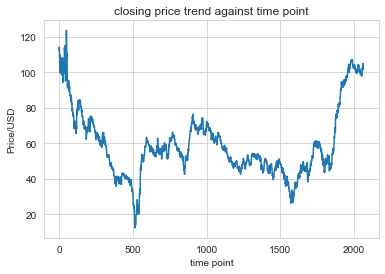

In [14]:
# plotting the price against time
fig = plt.figure()
plt.plot(data['time_point'], data['Price'])
plt.title('closing price trend against time point')
plt.ylabel('Price/USD')
plt.xlabel('time point')
fig.savefig('Price vs time')

## 3 Price Prediction Model-Machine Learning 

This section will test the performance of the following models:
1. Linear model: linear, LASSO, RIDGE, Polynomial
2. Tree model: GBDT, XGBoost, Random Forest

Simple models chosen since the size of the features is relatively small, simple model would avoid overfitting.

For each models, the corresponding feature engineering and the fine-tunning would be carried out individually.

### 3.1 Linear Model

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

#### 3.1.1 Feature Engineering

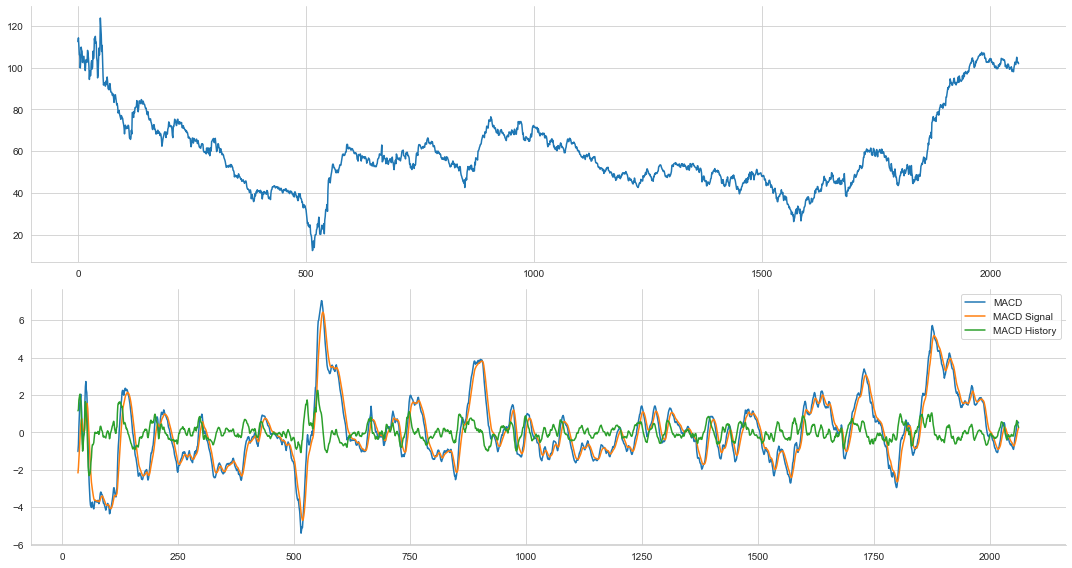

In [16]:
# introduce indicators to be features
# Bollinger band data
up, mid, low = BBANDS(data.Price, timeperiod=21,
                      nbdevup=2, nbdevdn=2, matype=0)
# RSI data
rsi = RSI(data.Price, timeperiod=14)
# MACD data
macd, macdsignal, macdhist = MACD(
    data.Price, fastperiod=12, slowperiod=26, signalperiod=9)
macd_data = pd.DataFrame({'AAPL': data.Price, 'MACD': macd,
                         'MACD Signal': macdsignal, 'MACD History': macdhist})
# plotting
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
macd_data.AAPL.plot(ax=axes[0])
macd_data.drop('AAPL', axis=1).plot(ax=axes[1])
fig.tight_layout()
sns.despine()

# insert signals into the dataset
data['BOLL_up'] = up
data['BOLL_mid'] = mid
data['BOLL_low'] = low
data['rsi14'] = rsi
data['macd12_26_9'] = macd

In [17]:
# checking if any null value
data.isnull().sum()

index             0
Date              0
Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
Interest_Rate     0
time_point        0
BOLL_up          20
BOLL_mid         20
BOLL_low         20
rsi14            14
macd12_26_9      33
dtype: int64

In [19]:
# remove the first 33 rows with null value
df = data[33:]
price = df.loc[:, 'Price']
# remove index
df = df.drop(['index', 'Date', 'Price'], axis=1)
columns = df.columns

In [20]:
# scaling the training data
scaler = StandardScaler()
scaler.fit_transform(df)

array([[ 2.45771094,  2.63300561,  2.2473184 , ...,  2.24954288,
         0.07943595, -0.57828914],
       [ 2.97571276,  2.91063725,  2.48921371, ...,  2.24738791,
         0.23037151, -0.36268357],
       [ 2.9115792 ,  2.97554523,  2.81155712, ...,  2.19135648,
         0.83189892,  0.16907502],
       ...,
       [ 2.40837743,  2.37337367,  2.42970416, ...,  2.39344532,
         0.40118515,  0.30275131],
       [ 2.37932548,  2.36355565,  2.42033692, ...,  2.39192764,
         0.45251982,  0.31557907],
       [ 2.42098488,  2.36028298,  2.38948011, ...,  2.3945128 ,
         0.20152716,  0.28777439]])

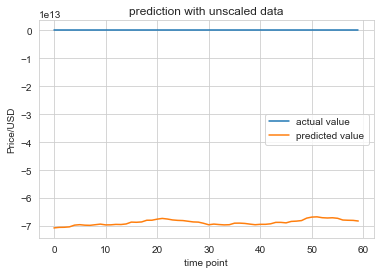

In [32]:
# below is a small demo for model trained with unscaled data, with the code below skipping the training process
# we can see the error is huge without the scaling 
# plotting the price against time
fig = plt.figure()
plt.plot(np.arange(60),y_test,label = 'actual value')
plt.plot(np.arange(60),model.predict(X_test),label = 'predicted value')
plt.title('prediction with unscaled data')
plt.ylabel('Price/USD')
plt.xlabel('time point')
plt.legend()
fig.savefig('Price vs time')

#### 3.1.2 Linear Regression

In [35]:
# Training data
X = df[['BOLL_up', 'BOLL_mid', 'BOLL_low', 'rsi14',
        'macd12_26_9', 'Interest_Rate']]  # selecting features
y = price  # target

# split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
# cross validation to measure the performance using mean suqared error
scores = cross_val_score(model, X, y,
                         scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-scores)
linear_rmse_scores

array([3.79444557, 1.29666332, 2.86961452, 1.04098435, 1.24470173,
       1.20686576, 0.98902943, 1.00360675, 1.50491211, 1.48045769])

In [83]:
# making prediction with linear model
linear_predict = model.predict(X_test)

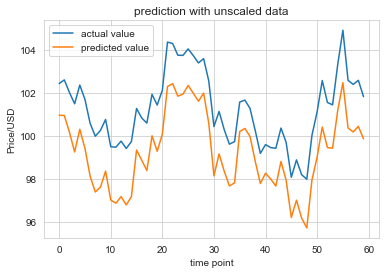

In [38]:
# plotting the price against time
fig = plt.figure()
plt.plot(np.arange(60),y_test,label = 'actual value')
plt.plot(np.arange(60),model.predict(X_test),label = 'predicted value')
plt.title('prediction with unscaled data')
plt.ylabel('Price/USD')
plt.xlabel('time point')
plt.legend()
fig.savefig('Price vs time')

#### 3.1.3 Polynomial Regression

In [39]:
# try different degrees of features

for deg in range(1, 6):  # try degree from 1 to 6
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    # cross validation to measure the performance
    scores = cross_val_score(poly_reg, X_poly, y,
                             scoring="neg_mean_squared_error", cv=10)
    poly_rmse_scores = np.sqrt(-scores)
    print('Degree: %d, mean rmse:%f' % (deg, np.mean(poly_rmse_scores)))
print('\nWill use degree = 2')

Degree: 1, mean rmse:1.633653
Degree: 2, mean rmse:1.602192
Degree: 3, mean rmse:2.592581
Degree: 4, mean rmse:7.639181
Degree: 5, mean rmse:52.479077

Will use degree = 2


In [40]:
# predict the price with the quadratic model
X_poly = poly_features.fit_transform(X_test)
poly_predict = poly_reg.predict(X_poly)

#### 3.1.4 Ridge and Lasso

In [ ]:
# find the best alpha(coefficient of penalty) for the ridge regression
alpha_range = np.arange(0, 1.1, 0.1)
best_alpha = 0  # start with 0, which equivalent to linear regression
best_error = 1e6  # random assign a huge value
# try all the alphas and select the best one
for i in alpha_range:
    ridge_reg = Ridge(alpha=i, solver="cholesky", random_state=42)
    ridge_reg.fit(X_train, y_train)
    scores = cross_val_score(
        ridge_reg, X, y, scoring="neg_mean_squared_error", cv=10)
    ridge_rmse_scores = np.sqrt(-scores)
    # compare the current mean sqaure error with the current lowest error
    if np.mean(ridge_rmse_scores) < best_error:
        best_alpha = i
        best_error = np.mean(ridge_rmse_scores)

In [42]:
# using closed form with matrix facotrisation by A-L Cholesky
ridge_reg = Ridge(alpha=best_alpha, solver="cholesky", random_state=42)
ridge_reg.fit(X_train, y_train)
scores = cross_val_score(
    ridge_reg, X, y, scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-scores)
ridge_rmse_scores

d:\python\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.46816e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
d:\python\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.9529e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
d:\python\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.87318e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
d:\python\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.23408e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
d:\python\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.58726e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


array([3.80000427, 1.29213804, 2.85444358, 1.04461639, 1.22070776,
       1.20563956, 0.93442849, 0.97483933, 1.48842232, 1.43478576])

In [ ]:
# find the best alpha(coefficient of penalty) for the lasso regression
alpha_range = np.arange(0, 1.1, 0.1)
best_alpha = 0  # start with 0, which equivalent to linear regression
best_error = 1e6  # random assign a huge value
# try all the alphas and select the best one
for i in alpha_range:
    lasso_reg = Lasso(alpha = i,random_state=42)  
    lasso_reg.fit(X_train, y_train)
    scores = cross_val_score(lasso_reg, X, y,scoring="neg_mean_squared_error", cv=10)
    lasso_rmse_scores = np.sqrt(-scores)
    # compare the current mean sqaure error with the current lowest error
    if np.mean(lasso_rmse_scores)<best_error:
        best_alpha = i
        best_error = np.mean(lasso_rmse_scores)

In [92]:
lasso_reg = Lasso(alpha=best_alpha,  random_state=42)  
lasso_reg.fit(X, y)
scores = cross_val_score(lasso_reg, X, y,scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-scores)
lasso_rmse_scores

array([3.82285251, 1.18583597, 2.86755624, 1.02313961, 1.20892706,
       1.11767732, 0.96046944, 1.00700865, 1.4867894 , 1.69086498])

In [48]:
# prediction with the two regularised models
lasso_predict = lasso_reg.predict(X_test)
ridge_predict = ridge_reg.predict(X_test)

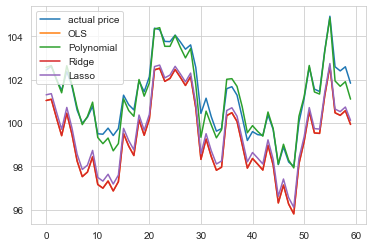

In [99]:
# plotting of the reuslts produced by all the models
plt.plot(np.arange(60),y_test,label='actual price')
plt.plot(np.arange(60),linear_predict,label='OLS')
plt.plot(np.arange(60),poly_predict,label='Polynomial')
plt.plot(np.arange(60),ridge_predict,label='Ridge')
plt.plot(np.arange(60),lasso_predict,label='Lasso')
plt.legend()

Polynomial is the best, Ridge seems perform better than Lasso

### 3.2 Tree Model

In [2]:
# import the tree models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost

#### 3.1.1Decision Tree

In [51]:
# train a GBDT tree model
dt_reg = DecisionTreeRegressor(random_state=42)  
dt_reg.fit(X, y)
scores = cross_val_score(dt_reg, X, y,scoring="neg_mean_squared_error", cv=10)
dt_rmse_scores = np.sqrt(-scores)
dt_rmse_scores

array([ 6.99310198,  1.58909647,  5.03029399,  1.74720128,  2.22841535,
        1.3077002 ,  1.94505759,  2.98617367,  1.88751277, 10.95938765])

#### 3.1.2 Random Forest

In [52]:
# train a random forest model
rf_reg = RandomForestRegressor(random_state=42)  
rf_reg.fit(X, y)
scores = cross_val_score(rf_reg, X, y,scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)
rf_rmse_scores

array([6.64189251, 1.44897012, 4.66335483, 1.11004086, 1.7749654 ,
       1.0935388 , 1.15456769, 2.57526619, 1.54653371, 8.05228822])

#### 3.1.3 XGBoost

In [53]:
# train a XGBoost model
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X, y)
scores = cross_val_score(xgb_reg, X, y,scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-scores)
xgb_rmse_scores

array([5.43445868, 1.79000922, 4.05697586, 1.7342648 , 1.43535498,
       1.36153609, 1.25283585, 2.35624463, 1.55127866, 5.88778379])

#### 3.1.4 Hyper-parameter Fine Tuning

The technique here is Grid Search, where all the combinations of the hyper-parameter would be evaluated and compared.

##### Decision Tree

In [36]:
# Decision Tree
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9]
             }

dt_reg = DecisionTreeRegressor(random_state=42)  
grid_search = GridSearchCV(dt_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [37]:
# output the best combination of hyper-parameters
grid_search.best_params_

{'ccp_alpha': 0.01, 'max_depth': 6, 'max_features': 'auto'}

In [77]:
# apply the best output
dt_reg = DecisionTreeRegressor(random_state=42,ccp_alpha=0.01, max_depth= 6, max_features= 'auto')
dt_reg.fit(X, y)
scores = cross_val_score(dt_reg, X, y,scoring="neg_mean_squared_error", cv=10)
dt_rmse_scores = np.sqrt(-scores)
dt_rmse_scores

array([ 7.10631434,  1.93022186,  5.11428169,  2.33366749,  2.31952247,
        1.67954484,  2.12779217,  4.35705228,  2.34800614, 11.07240482])

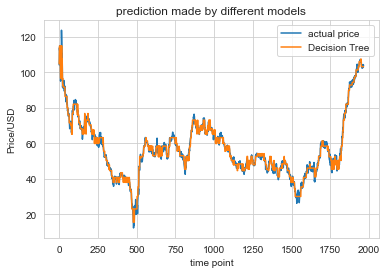

In [78]:
# plot the reuslts of the decision tree with traing data
# the reuslt seems perfectly well (but poor in test data thus overfitting, will see later)
plt.plot(np.arange(1966),y_train,label='actual price')
plt.plot(np.arange(1966),dt_reg.predict(X_train),label='Decision Tree')

plt.title('prediction made by different models')
plt.ylabel('Price/USD')
plt.xlabel('time point')
plt.legend()

##### Random Forest

In [186]:
# random forest hyper-parameter
param_grid = {
    'n_estimators': [200, 500],
    'max_features':['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8]}

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [187]:
grid_search.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

In [56]:
rf_reg = RandomForestRegressor(random_state=42,max_depth=8, max_features= 'sqrt',n_estimators=500)
rf_reg.fit(X, y)
scores = cross_val_score(rf_reg, X, y,scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)
rf_rmse_scores

array([5.88171632, 1.53065273, 5.69432472, 1.33385569, 1.77713703,
       1.22665004, 1.36462272, 2.01623528, 1.91516506, 3.73111135])

##### XGBoost

In [39]:
# xgboost
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

xgb_reg = xgboost.XGBRegressor(random_state=42)

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

In [57]:
xgb_reg = xgboost.XGBRegressor(random_state=42, colsample_bytree=1.0,gamma=0.5,max_depth=5, min_child_weight=1,subsample=0.6)
xgb_reg.fit(X, y)
scores = cross_val_score(
    xgb_reg, X, y, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-scores)
xgb_rmse_scores

array([6.60610974, 1.74295694, 3.82130949, 1.59425093, 2.00249686,
       1.16044097, 1.22220664, 1.49680886, 1.75950826, 3.83858571])

In [79]:
# predict all the results with the tree models
xgb_predict = xgb_reg.predict(X_test)
rf_predict = rf_reg.predict(X_test)
dt_predict = dt_reg.predict(X_test)

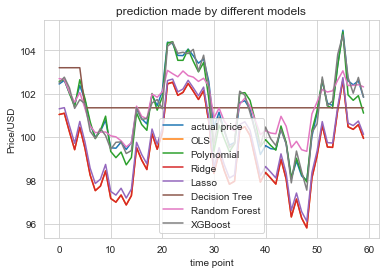

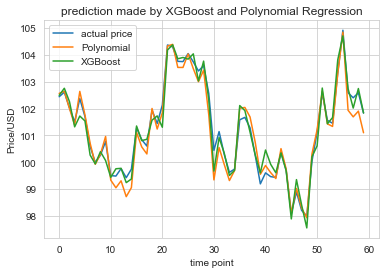

In [123]:
# plotting the all the results
fig = plt.figure()
plt.plot(np.arange(60),y_test,label='actual price')
plt.plot(np.arange(60),linear_predict,label='OLS')
plt.plot(np.arange(60),poly_predict,label='Polynomial')
plt.plot(np.arange(60),ridge_predict,label='Ridge')
plt.plot(np.arange(60),lasso_predict,label='Lasso')
plt.plot(np.arange(60),dt_predict,label='Decision Tree')
plt.plot(np.arange(60),rf_predict,label='Random Forest')
plt.plot(np.arange(60),xgb_predict,label='XGBoost')
plt.title('prediction made by different models')
plt.ylabel('Price/USD')
plt.xlabel('time point')
plt.legend()
fig2 = plt.figure()
plt.plot(np.arange(60),y_test,label='actual price')
plt.plot(np.arange(60),poly_predict,label='Polynomial')
plt.plot(np.arange(60),xgb_predict,label='XGBoost')
plt.title('prediction made by XGBoost and Polynomial Regression')
plt.ylabel('Price/USD')
plt.xlabel('time point')
plt.legend()
#fig.savefig('Price vs time')#

### 3.3 Conclusion

As expected, simple models would perform better as complex model is more likely to overfit the data, and also the features is relatively few. The polynomial regression has the best performance. XGBoost has the best performance in tree model after fine-tuning the hyper-parameter, while the tree models performs slightly worse than the linear models,but both types obtain statisfying results with error less than 10 except the overfitting pure decision tree.

## 4 Price Prediction Model-Neural Network

This section will test the performance of the following models:
1. normal data: ANN, CNN, LSTM
2. high dimensional time series data: LSTM, CNN-LSTM

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, MaxPool1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

### 4.1 ANN

In [324]:
# remove the first 33 with null value
df = data[33:]
df = df.drop(['index', 'Date', 'Price'], axis=1)

# scaling the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
# now lets split data in test train pairs
X_train, X_test, y_train, y_test = train_test_split(
    scaled_df, price, test_size=0.2, shuffle=False)

In [286]:
# simple ANN
def regressor(inp_dim):

    model = Sequential()

    model.add(Dense(20, input_dim=inp_dim,
              kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


# Model Training
ann_model = regressor(inp_dim=X_train.shape[1])  # dimension of X
ann_model.fit(X_train, y_train, epochs=70, validation_split=0.2)

Epoch 1/70
41/41 [==============================] - 0s 4ms/step - loss: 3575.0127 - val_loss: 1932.1841
Epoch 2/70
41/41 [==============================] - 0s 1ms/step - loss: 3540.9827 - val_loss: 1878.6885
Epoch 3/70
41/41 [==============================] - 0s 1ms/step - loss: 3256.3811 - val_loss: 1578.2383
Epoch 4/70
41/41 [==============================] - 0s 1ms/step - loss: 2142.2432 - val_loss: 868.3629
Epoch 5/70
41/41 [==============================] - 0s 1ms/step - loss: 628.0602 - val_loss: 450.0569
Epoch 6/70
41/41 [==============================] - 0s 1ms/step - loss: 295.0574 - val_loss: 479.3099
Epoch 7/70
41/41 [==============================] - 0s 1ms/step - loss: 260.5534 - val_loss: 481.5647
Epoch 8/70
41/41 [==============================] - 0s 1ms/step - loss: 235.8426 - val_loss: 489.8185
Epoch 9/70
41/41 [==============================] - 0s 1ms/step - loss: 214.0250 - val_loss: 484.4442
Epoch 10/70
41/41 [==============================] - 0s 1ms/step - loss: 19

Accuracy score of the predictions: 0.994627519729953


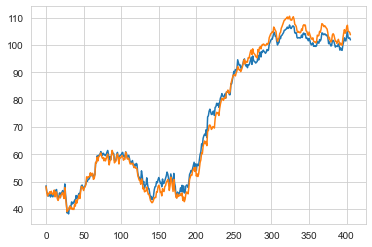

In [287]:
# Measure the Accuracy Score
print("Accuracy score of the predictions: {0}".format(
    r2_score(y_test, ann_pred)))

# Prediction
ann_pred = ann_model.predict(X_test)
fig = plt.figure()
plt.plot(np.arange(len(y_test)), y_test, label='actual price')
plt.plot(np.arange(len(y_test)), ann_pred, label='ANN')

### 4.2 CNN

In [288]:
# CNN
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)


def reg():

    model = Sequential()

    model.add(Conv1D(32, kernel_size=(3,), padding='same',
              activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=(5,), padding='same', activation='relu'))

    model.add(Flatten())

    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


cnn_model = reg()
cnn_model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
41/41 [==============================] - 1s 6ms/step - loss: 1355.8131 - val_loss: 323.4949
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 266.5468 - val_loss: 131.8398
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 124.5631 - val_loss: 50.7769
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 46.6097 - val_loss: 12.1251
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 13.0501 - val_loss: 4.3109
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 5.0404 - val_loss: 2.0266
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 2.2985 - val_loss: 1.5224
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 1.7709 - val_loss: 1.3575
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4142 - val_loss: 2.2908
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4551 - val_loss: 0

Epoch 83/100
41/41 [==============================] - 0s 4ms/step - loss: 0.2721 - val_loss: 0.2320
Epoch 84/100
41/41 [==============================] - 0s 4ms/step - loss: 0.2473 - val_loss: 0.6302
Epoch 85/100
41/41 [==============================] - 0s 3ms/step - loss: 0.3691 - val_loss: 0.2606
Epoch 86/100
41/41 [==============================] - 0s 3ms/step - loss: 0.4258 - val_loss: 2.1001
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 0.4136 - val_loss: 0.2473
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 0.2574 - val_loss: 0.3855
Epoch 89/100
41/41 [==============================] - 0s 3ms/step - loss: 0.3490 - val_loss: 0.2176
Epoch 90/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6415 - val_loss: 1.8755
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 0.3904 - val_loss: 0.3449
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 0.4486 - val_loss: 0.2015


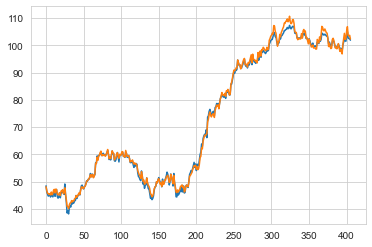

In [289]:
# Prediction
cnn_pred = cnn_model.predict(X_test)
fig = plt.figure()
plt.plot(np.arange(len(y_test)), y_test, label='actual price')
plt.plot(np.arange(len(y_test)), cnn_pred, label='CNN')

### 4.3 LSTM

In [389]:
# remove the first 33 with null value
df = data[33:]
df = df.drop(['index', 'Date', 'Price'], axis=1)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [390]:
# now lets split data in test train pairs to fit the LSTM shape
X_train, X_test, y_train, y_test = train_test_split(
    scaled_df, price, test_size=0.2, shuffle=False)
X_train_ = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_ = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [312]:
def reg():
    model = Sequential()

    model.add(LSTM(70, return_sequences=True,
              input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(70, return_sequences=True))
    model.add(LSTM(70))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


# Model Training
lstm_model = reg()

In [313]:
lstm_model.fit(X_train_, y_train, epochs=250, validation_split=0.2)

Epoch 1/250
41/41 [==============================] - 8s 42ms/step - loss: 2992.7026 - val_loss: 1080.2415
Epoch 2/250
41/41 [==============================] - 1s 16ms/step - loss: 2237.3042 - val_loss: 874.9614
Epoch 3/250
41/41 [==============================] - 1s 16ms/step - loss: 1968.4349 - val_loss: 710.4486
Epoch 4/250
41/41 [==============================] - 1s 16ms/step - loss: 1735.2065 - val_loss: 578.2316
Epoch 5/250
41/41 [==============================] - 1s 16ms/step - loss: 1538.5084 - val_loss: 467.1021
Epoch 6/250
41/41 [==============================] - 1s 16ms/step - loss: 1365.1826 - val_loss: 374.0403
Epoch 7/250
41/41 [==============================] - 1s 16ms/step - loss: 1212.1248 - val_loss: 296.0515
Epoch 8/250
41/41 [==============================] - 1s 17ms/step - loss: 1076.1821 - val_loss: 231.3403
Epoch 9/250
41/41 [==============================] - 1s 17ms/step - loss: 956.1847 - val_loss: 178.5964
Epoch 10/250
41/41 [==============================] - 1

Epoch 159/250
41/41 [==============================] - 1s 16ms/step - loss: 3.0162 - val_loss: 1.3483
Epoch 160/250
41/41 [==============================] - 1s 17ms/step - loss: 2.8383 - val_loss: 1.9639
Epoch 161/250
41/41 [==============================] - 1s 17ms/step - loss: 2.8920 - val_loss: 1.6463
Epoch 162/250
41/41 [==============================] - 1s 17ms/step - loss: 2.6506 - val_loss: 2.0212
Epoch 163/250
41/41 [==============================] - 1s 16ms/step - loss: 2.7444 - val_loss: 0.8815
Epoch 164/250
41/41 [==============================] - 1s 16ms/step - loss: 2.4796 - val_loss: 1.6695
Epoch 165/250
41/41 [==============================] - 1s 17ms/step - loss: 2.4977 - val_loss: 1.3345
Epoch 166/250
41/41 [==============================] - 1s 16ms/step - loss: 2.4581 - val_loss: 1.2891
Epoch 167/250
41/41 [==============================] - 1s 16ms/step - loss: 2.5580 - val_loss: 1.5296
Epoch 168/250
41/41 [==============================] - 1s 16ms/step - loss: 2.2981

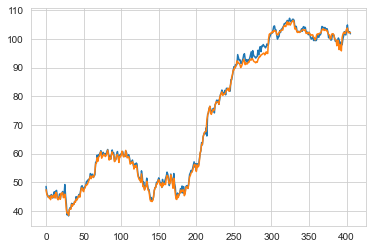

In [314]:
# Prediction on test data
lstm_pred = lstm_model.predict(X_test_)
fig = plt.figure()
plt.plot(np.arange(len(y_test)), y_test, label='actual price')
plt.plot(np.arange(len(y_test)), lstm_pred, label='LSTM')

Text(0, 0.5, 'Price/USD')

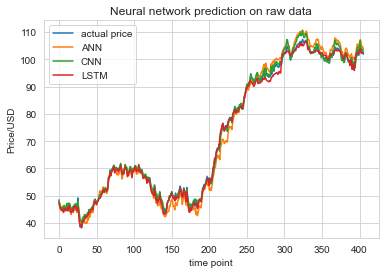

In [391]:
# plot all the results
plt.plot(np.arange(len(y_test)), y_test, label='actual price')
plt.plot(np.arange(len(y_test)), ann_pred, label='ANN')
plt.plot(np.arange(len(y_test)), cnn_pred, label='CNN')
plt.plot(np.arange(len(y_test)), lstm_pred, label='LSTM')
plt.legend()
plt.title('Neural network prediction on raw data')
plt.xlabel('time point')
plt.ylabel('Price/USD')

### 4.4 LSTM (high dimension data)

In [328]:
# transform the data into time series high dimension data
def lstm_split(data, n_steps):
    X = []
    y = []
    for step in range(len(data)-n_steps+1):
        # (n_steps-1) layers would be added to represent the time series data
        X.append(data[step:step+n_steps, :-1])
        # y will be the value of the last column which is our target(price)
        y.append(data[step+n_steps-1, -1])

    return np.array(X).astype("float32"), np.array(y).astype("float32")

In [329]:
# remove the first 33 with null value
df = data[33:]
df = df.drop(['index', 'Date'], axis=1)

# Training data
X = df[['Vol.', 'BOLL_up', 'BOLL_mid', 'BOLL_low', 'rsi14',
        'macd12_26_9', 'Interest_Rate', 'Price']]  # features including target


# predict suing the previous 5 day
X1, y1 = lstm_split(X.values, n_steps=5)

# split the
train_split_size = 0.8
split_index = int(np.ceil(len(X1)*train_split_size))
date_index = X.index

X_train, X_test = X1[:split_index], X1[split_index:]
y_train, y_test = y1[:split_index], y1[split_index:]

X_train_date, X_test_date = date_index[:split_index], date_index[split_index:]

X_train.shape

(1618, 5, 7)

In [331]:
# buidling the vanilla model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]),
               activation='relu', return_sequences=True))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 5, 32)             5120      
_________________________________________________________________
dense_54 (Dense)             (None, 5, 1)              33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [370]:
# train the model
lstm_model.fit(X_train, y_train, epochs=200, batch_size=4,
               verbose=2, validation_split=0.2, shuffle=False)

Epoch 1/50
324/324 - 1s - loss: 79.0248 - val_loss: 14.4293
Epoch 2/50
324/324 - 1s - loss: 79.3116 - val_loss: 14.4418
Epoch 3/50
324/324 - 1s - loss: 79.1810 - val_loss: 14.4525
Epoch 4/50
324/324 - 1s - loss: 79.0517 - val_loss: 14.4616
Epoch 5/50
324/324 - 1s - loss: 78.9136 - val_loss: 14.4712
Epoch 6/50
324/324 - 1s - loss: 78.7690 - val_loss: 14.4823
Epoch 7/50
324/324 - 1s - loss: 78.6186 - val_loss: 14.4953
Epoch 8/50
324/324 - 1s - loss: 78.4632 - val_loss: 14.5105
Epoch 9/50
324/324 - 1s - loss: 78.3028 - val_loss: 14.5281
Epoch 10/50
324/324 - 1s - loss: 78.1380 - val_loss: 14.5478
Epoch 11/50
324/324 - 1s - loss: 77.9690 - val_loss: 14.5694
Epoch 12/50
324/324 - 1s - loss: 77.7960 - val_loss: 14.5929
Epoch 13/50
324/324 - 1s - loss: 77.6193 - val_loss: 14.6179
Epoch 14/50
324/324 - 1s - loss: 77.4393 - val_loss: 14.6442
Epoch 15/50
324/324 - 1s - loss: 77.2564 - val_loss: 14.6716
Epoch 16/50
324/324 - 1s - loss: 77.0706 - val_loss: 14.6998
Epoch 17/50
324/324 - 1s - loss: 

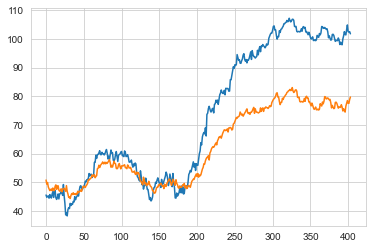

In [372]:
# making prediction
lstm_pred_high = lstm_model.predict(X_test)
lstm_pred_high = lstm_pred_high.flatten()
# plot the results
fig = plt.figure()
plt.plot(np.arange(len(y_test)), y_test, label='actual price')
plt.plot(np.arange(len(y_test)), lstm_pred_high, label='LSTM high')

### 4.4 CNN-LSTM (high dimension data)

In [373]:
# Training data
X = df[['Vol.', 'BOLL_up', 'BOLL_mid', 'BOLL_low', 'rsi14',
        'macd12_26_9', 'Interest_Rate', 'Price']]  # features

# predict suing the previous 3 days, this time tehe number is reduced to avoid the extra complexity
X1, y1 = lstm_split(X.values, n_steps=3)

train_split_size = 0.8
split_index = int(np.ceil(len(X1)*train_split_size))
date_index = X.index

X_train, X_test = X1[:split_index], X1[split_index:]
y_train, y_test = y1[:split_index], y1[split_index:]

X_train_date, X_test_date = date_index[:split_index], date_index[split_index:]

X_train.shape

(1620, 3, 7)

In [379]:
# the model will begins with 2 convolutional layers
CNN_LSTM_model = Sequential()
CNN_LSTM_model.add(Conv1D(32, kernel_size=(3,), padding='same', activation='relu'))
CNN_LSTM_model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
CNN_LSTM_model.add(Flatten())

# then 2 LSTM layers
CNN_LSTM_model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)))
CNN_LSTM_model.add(LSTM(70, return_sequences=True))
CNN_LSTM_model.add(LSTM(70))
CNN_LSTM_model.add(Dense(1))

# Final layers
CNN_LSTM_model.add(Dense(1, activation='linear'))
CNN_LSTM_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# declare the correct input shape of the data
input_shape = (None, 3, 7)
CNN_LSTM_model.build(input_shape=input_shape)
CNN_LSTM_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 3, 32)             704       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 3, 64)             6208      
_________________________________________________________________
flatten_18 (Flatten)         (None, 192)               0         
_________________________________________________________________
lambda_20 (Lambda)           (None, 1, 192)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 1, 70)             73640     
_________________________________________________________________
lstm_64 (LSTM)               (None, 70)                39480     
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

In [381]:
epochs = 300
batch_size = 5
lr_epochs=20
CNN_LSTM_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_split=0.2)

Epoch 1/300
260/260 [==============================] - 6s 5ms/step - loss: 2707.2690 - mse: 2707.2690 - mae: 49.5186 - val_loss: 559.5768 - val_mse: 559.5768 - val_mae: 22.7591
Epoch 2/300
260/260 [==============================] - 1s 2ms/step - loss: 888.7639 - mse: 888.7639 - mae: 25.9865 - val_loss: 41.6057 - val_mse: 41.6057 - val_mae: 5.1923
Epoch 3/300
260/260 [==============================] - 1s 2ms/step - loss: 277.0066 - mse: 277.0066 - mae: 12.6501 - val_loss: 177.9541 - val_mse: 177.9541 - val_mae: 11.6790
Epoch 4/300
260/260 [==============================] - 1s 2ms/step - loss: 216.2423 - mse: 216.2423 - mae: 10.9568 - val_loss: 242.8081 - val_mse: 242.8081 - val_mae: 14.1863
Epoch 5/300
260/260 [==============================] - 1s 2ms/step - loss: 214.6731 - mse: 214.6731 - mae: 10.9342 - val_loss: 253.1858 - val_mse: 253.1858 - val_mae: 14.5481
Epoch 6/300
260/260 [==============================] - 1s 2ms/step - loss: 214.6050 - mse: 214.6049 - mae: 10.9520 - val_loss:

260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4042 - val_mse: 251.4042 - val_mae: 14.4720
Epoch 94/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4058 - val_mse: 251.4058 - val_mae: 14.4720
Epoch 95/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4051 - val_mse: 251.4051 - val_mae: 14.4720
Epoch 96/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9793 - mse: 212.9793 - mae: 10.9141 - val_loss: 251.4065 - val_mse: 251.4065 - val_mae: 14.4721
Epoch 97/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4072 - val_mse: 251.4072 - val_mae: 14.4721
Epoch 98/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4

Epoch 139/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 140/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 141/300
lr changed to 1.000000082740371e-10
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 142/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 143/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 144/300
260/260 [==============================] - 1s 2ms/step - loss: 21

Epoch 185/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 186/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 187/300
260/260 [==============================] - 1s 3ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 188/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 189/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 190/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.914

Epoch 231/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 232/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 233/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 234/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 235/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 236/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9792 - mse: 212.9792 - mae: 10.914

Epoch 277/300
260/260 [==============================] - 1s 3ms/step - loss: 212.9790 - mse: 212.9790 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 278/300
260/260 [==============================] - 1s 3ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 279/300
260/260 [==============================] - 1s 2ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 280/300
260/260 [==============================] - 1s 3ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 281/300
lr changed to 1.0000000830368326e-17
260/260 [==============================] - 1s 3ms/step - loss: 212.9791 - mse: 212.9791 - mae: 10.9141 - val_loss: 251.4023 - val_mse: 251.4023 - val_mae: 14.4719
Epoch 282/300
260/260 [==============================] - 1s 2ms/step - loss: 2

Accuracy score of the predictions: -0.37167820049335965


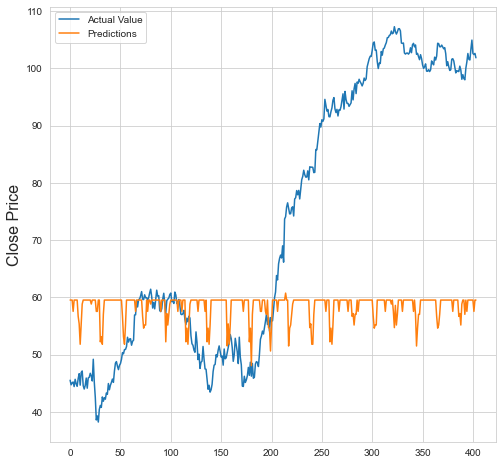

In [284]:
# Prediction
CNN_LSTM_pred = CNN_LSTM_model.predict(X_test).reshape(len(X_test))

# Measure the Accuracy Score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, CNN_LSTM_pred)))

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': CNN_LSTM_pred.flatten()})
pred_df.head()

plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

Conclusion: Small data size, simple model would perform better but complex would easily get overfitting.

## 5 Trading Signals-Classical Indicator

This section would verify the effect for the classical indcators

Assumption:

buying: would be "all-in", which buy as much stocks as possible with the available cash

selling:would be "all-out", which sell as much stocks as possible

In [166]:
# declare the buying function
def buy(order, cash, price):
    order_before = order  # record the order before placing order
    cash_before = cash  # record teh cash before placing order
    
    # use all avaible cash to buy as much stocks
    order += cash_before//price
    cash -= (order-order_before)*price
    return cash, order

# declare the selling function
def sell(order, cash, price):
    # sell all the stocks
    cash += order*price
    order = 0
    return cash, order

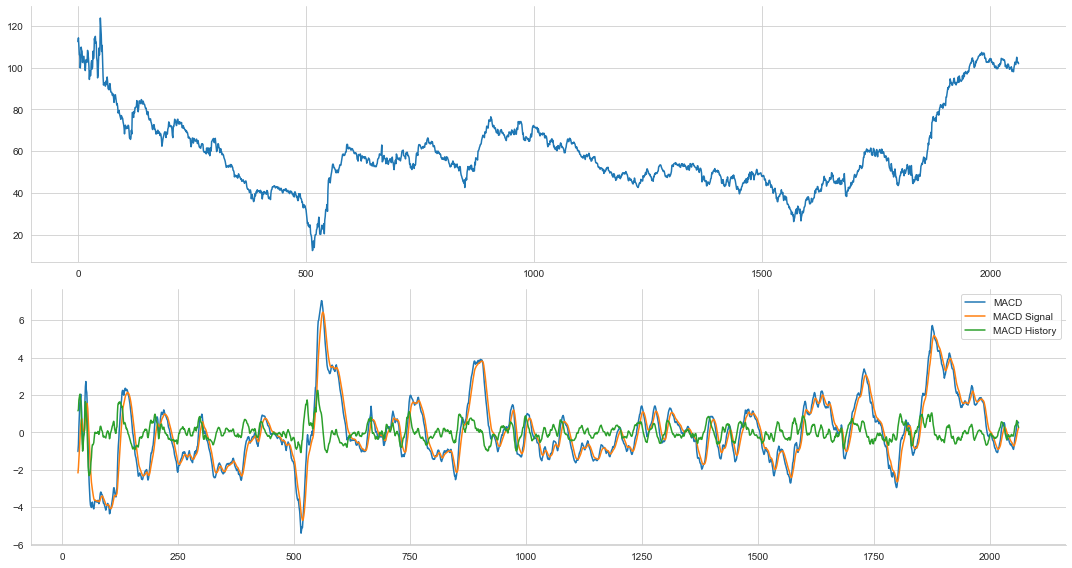

In [163]:
# introduce indicators to be features
# Bollinger band data
up, mid, low = BBANDS(data.Price, timeperiod=21,
                      nbdevup=2, nbdevdn=2, matype=0)
# RSI data
rsi = RSI(data.Price, timeperiod=14)
# MACD data
macd, macdsignal, macdhist = MACD(
    data.Price, fastperiod=12, slowperiod=26, signalperiod=9)
macd_data = pd.DataFrame({'AAPL': data.Price, 'MACD': macd,
                         'MACD Signal': macdsignal, 'MACD History': macdhist})
# plotting
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
macd_data.AAPL.plot(ax=axes[0])
macd_data.drop('AAPL', axis=1).plot(ax=axes[1])
fig.tight_layout()
sns.despine()

# insert signals into the dataset
data['BOLL_up'] = up
data['BOLL_mid'] = mid
data['BOLL_low'] = low
data['rsi14'] = rsi
data['macd12_26_9'] = macd

In [164]:
# remove the first 33 rows with null value
df = data[33:]
# remove index
df = df.drop(['index','Date'],axis=1)
# take time point as index
df['time_point']=np.arange(len(df))
df = df.set_index('time_point')

### 5.1 MACD

### 5.1.1 Test the performance

The first signal being tested is the MACD_12_26_9, where 12 is the time period for the fast period line, 26 is the slow period line and 9 for the signal period line. 

The method to use MACD is simple: when the fast line crosses the slow line from below, it indicates that the price will go up which means at this time point buying stocks is likely to earn.

When the fast line crosses the slow line from above, the market is likely to go down and therefore it is better to sell in order to prevent the loss. MACD is the difference between the fast value and the slow value. 

In [360]:
# assign initial values for cash
initial_cash = 1e6
available_cash = initial_cash
order = 0

for i in range(1, len(df)):
    # the two lines cross each others therefore MACD change signs
    if df['macd12_26_9'][i-1]*df['macd12_26_9'][i] < 0:
        if df['macd12_26_9'][i-1] > df['macd12_26_9'][i]:  # positive to negative, bearish prospect
            available_cash, order = sell(order, available_cash, df['Price'][i])
        else:  # negative to positive, bullish prospect
            available_cash, order = buy(order, available_cash, df['Price'][i])

# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:356601.720000
Profit rate: 35.660000%


### 5.1.2 Test effect in improved scale

At the time when Geral Appel created the original MACD, the American stocks market has 6 market days in a week and on average 26 market days per month, and these are where the fast and slow time period come from: two market weeks is twice six which is 12, and 26 for a month by subtracting four non-market days from 30 days. As for the signal period line, it is calculated with the formula 6(1+1/√2Π)≈9, where 1/√2Π is the coefficient for the normal distibution. Since the number of market days is 5 at the current market, the parameter could therefore be 10,20 and 7. For this reason, the MACD_10_20_7 is created and tested over the dataset, the reuslts would be given and discussed later.

In [470]:
# modification in the parameters
macd, macdsignal, macdhist = MACD(
    data.Price, fastperiod=10, slowperiod=22, signalperiod=7)
data['macd10_20_7'] = macd

# remove the first 33 rows with null value
df = data[33:]
# remove index
df = df.drop(['index', 'Date'], axis=1)
# take time point as index
df['time_point'] = np.arange(len(df))
df = df.set_index('time_point')

In [474]:
# assign initial values for cash
initial_cash = 1e6
available_cash = initial_cash
order = 0

for i in range(1, len(df)):
    if df['macd10_20_7'][i-1]*df['macd10_20_7'][i] < 0:
        if df['macd10_20_7'][i-1] > df['macd10_20_7'][i]: # positive to negative, bearish prospect
            available_cash,order = sell(order,available_cash,df['Price'][i])
        else: # negative to positive, bullish prospect
            available_cash,order = buy(order,available_cash,df['Price'][i])

# calculate the revenue and profit rate            
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:1111103.170000
Profit rate: 111.110000%


Modification seems to work!

### 5.2 RSI

RSI >80: overheated, price will drop

RSI >50: strong long-position, price will increase

RSI <50: strong short-position, price will drop

RSI <20: overcold, price will rise

In [180]:
# assign initial values for cash
initial_cash = 1e6
available_cash = initial_cash
order = 0

for i in range(len(df)):
    if df['rsi14'][i] > 80:  # overheated, bearish prospect
        available_cash, order = sell(order, available_cash, df['Price'][i])
    elif df['rsi14'][i] > 50:  # strong long-position, bullish prospect
        available_cash, order = buy(order, available_cash, df['Price'][i])
    elif df['rsi14'][i] > 20:  # strong short-position, bearish prospect
        available_cash, order = sell(order, available_cash, df['Price'][i])
    else:  # overcold, bearish prospect
        available_cash, order = buy(order, available_cash, df['Price'][i])

# calculate the revenue and profit rate            
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:281846.050000
Profit rate: 28.180000%


### 5.3 Bollinger Band

K-line cross the lower band, price will increase

K-line crosses the middle band from below, price will increase

K line oscillate between the middle and the upper band, price will increase

K line crossing the middle band from above price will drop

In [131]:
# assign initial values for cash
initial_cash = 1e6
available_cash = initial_cash
order = 0

for i in range(len(df)):
    # K-line cross the lower band, price will increase
    if (df['Open'][i] < df['BOLL_low'][i]) and (df['Price'][i] > df['BOLL_low'][i]):
        available_cash, order = buy(order, available_cash, df['Price'][i])

    # K-line crosses the middle band from below, price will increase
    elif (df['Open'][i] < df['BOLL_mid'][i]) and (df['Price'][i] > df['BOLL_mid'][i]):
        available_cash, order = buy(order, available_cash, df['Price'][i])

    # K line oscillate between the middle and the upper band, price will increase
    elif (df['Open'][i] > df['BOLL_mid'][i]) and (df['Price'][i] < df['BOLL_up'][i]) and (df['Price'][i] > df['Open'][i]):
        available_cash, order = buy(order, available_cash, df['Price'][i])
        
    # K line crossing the middle band from above price will drop
    elif (df['Open'][i] > df['BOLL_mid'][i]) and (df['Price'][i] < df['BOLL_mid'][i]):
        available_cash, order = sell(order, available_cash, df['Price'][i])

# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:-990913.870000
Profit rate: -99.090000%


### 5.4 KDJ

When the D value drops from above to some point below 80, the stock would be sold; 
when it rise from below to some point above 20, the buying order would be placed; when K and D are both below 20 but once the K line crosses the D line from below, the market is likely to be stronger and therefore buying order would be placed; and finally when K and D are both greater than 80 but K drops from above to some point smaller than D would hint the market dropping soon, thus the selling order would be placed.

In [365]:
# assign initial values for cash
initial_cash = 1e6
available_cash = initial_cash
order = 0

for i in range(1, len(df)):

    # D value drop below 80 from above, bearish prospect
    if (df['slowD'][i-1] > 80) and (df['slowD'][i] < 80):
        available_cash, order = sell(order, available_cash, df['Price'][i])

    # D value rise above 20 from below, bullish prospect
    elif (df['slowD'][i-1] < 20) and (df['slowD'][i] > 20):
        available_cash, order = buy(order, available_cash, df['Price'][i])

    # K and D both below 20, K crosses D from below, bullish prospect
    elif (df['slowD'][i] < 20) and (df['slowK'][i] < 20) and (df['slowD'][i-1] > df['slowK'][i-1]) and (df['slowD'][i] < df['slowK'][i]):
        available_cash, order = buy(order, available_cash, df['Price'][i])

    # K and D both above 80, K crosses D from below, bearish prospect
    elif (df['slowD'][i] > 80) and (df['slowK'][i] > 80) and (df['slowD'][i-1] < df['slowK'][i-1]) and (df['slowD'][i] > df['slowK'][i]):
        available_cash, order = sell(order, available_cash, df['Price'][i])

# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:329522.130000
Profit rate: 32.950000%


## 6 Trading Signals-Chart Analysis Signals

This section will demonstrate the four chart patterns and test their effect in the trading timing

AttributeError: module 'mpl_finance' has no attribute 'plt'

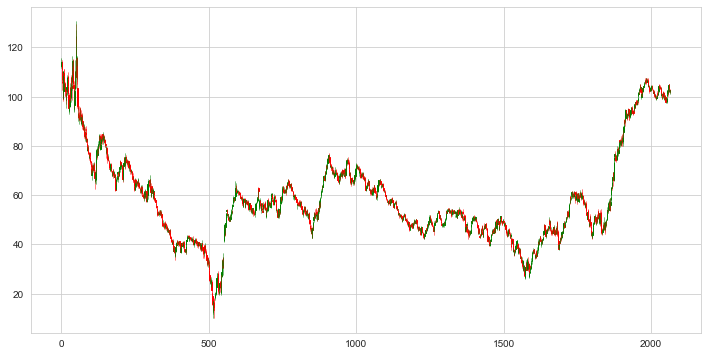

In [424]:
import mpl_finance as mpf
# plot K-line
ohlc = data[['time_point', 'Open', 'High', 'Low', 'Price']]
f1, ax = plt.subplots(figsize=(12, 6))
mpf.candlestick_ohlc(ax, ohlc.values.tolist(), width=.7,
                     colorup='red', colordown='green')
mpf.plt()

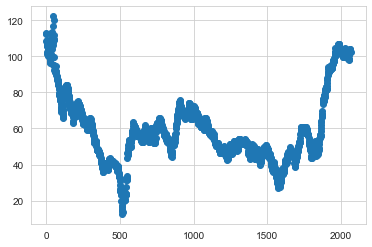

In [168]:
# create mid column to express the genral pattern of the K-line
df = data
df = df.reset_index()
# determine the mid value of the day by averaging the open and close price
df['mid'] = [((df['Price'][i]+df['Open'][i])/2) for i in range(len(df))]
plt.scatter(df['index'], df['mid'])

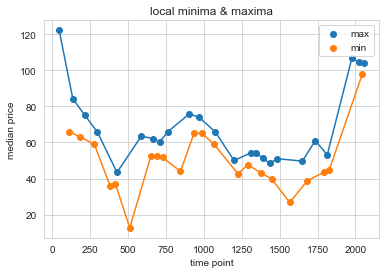

In [171]:
# create two list for local maximum and local minimum  for the K-line
width  = 30 # number of the adjacent points when determining the local maxima/minima

mid_price = df['mid'][:position]
local_max = [] # list for local maxima
local_min = [] # list for local minima

for i in range(width,len(mid_price)):
    # local maximum will be greater than any points in its neighbour
    if mid_price[i] >= max(mid_price[i-width:i+width]):
        local_max.append(i)
    # local minimum will be smaller than any points in its neighbour
    elif mid_price[i] <= min(mid_price[i-width:i+width]):
        local_min.append(i)
        
# visualise the maximum plot and minimum plot
plt.scatter(local_max,mid_price[local_max].tolist(),label = 'max')
plt.scatter(local_min,mid_price[local_min].tolist(),label = 'min')
plt.xlabel('time point')
plt.ylabel('median price')
plt.title('local minima & maxima')
plt.legend()

In [173]:
# making discrete data
# this block is aimed to creating steps between the adjacent maxima or minima

# maxima
# a list to record the TIME STEP, begin with the smallest time point in maxima
max_step = [min(local_max)]
# a list to record the PRICE, begin with the price corresponding to the smallest time point in maxima
max_value = [df['mid'][min(local_max)]]
# calculate the gradient between two maxima
gradient = ((df['mid'][local_max[1]]-df['mid'][local_max[0]]) /
            (local_max[1]-local_max[0]))
high_gradient_list = [gradient] # the consequent gradient for the upper line

marker = 1 # pointer in list recording the position of gradient change
for i in range(min(local_max)+1, max(local_max)+1):
    max_step.append(i) # one step forward
    if i == local_max[marker] and i != max(local_max): # i is the number for gradient change but not the last one in the list
        marker += 1 # move to the next number of gradient change
        # calculate the updated gradient at the current point
        gradient = ((df['mid'][local_max[marker]]-df['mid']
                    [local_max[marker-1]])/(local_max[marker]-local_max[marker-1])) 
    high_gradient_list.append(gradient) # append the graident at the current point
    max_value.append(max_value[-1]+gradient) # append the price at the current point
    

# minima
# a list to record the TIME STEP, begin with the smallest time point in minima
min_step = [min(local_min)]
# a list to record the PRICE, begin with the price corresponding to the smallest time point in minima
min_value = [df['mid'][min(local_min)]]
# calculate the gradient between two maxima
gradient = ((df['mid'][local_min[1]]-df['mid'][local_min[0]]) /
            (local_min[1]-local_min[0]))
low_gradient_list = [gradient] # the consequent gradient for the lower line
marker = 1 # pointer in list recording the position of gradient change
for i in range(min(local_min)+1, max(local_min)+1): 
    min_step.append(i) # one step forward
    if i == local_min[marker] and i != max(local_min): # i is the number for gradient change but not the last one in the list
        marker += 1 # move to the next number of gradient change
        # calculate the updated gradient at the current point
        gradient = ((df['mid'][local_min[marker]]-df['mid']
                    [local_min[marker-1]])/(local_min[marker]-local_min[marker-1])) 
    low_gradient_list.append(gradient) # append the graident at the current point
    min_value.append(min_value[-1]+gradient) # append the price at the current point


#select the patterns in which both upper line and lower line are 
pattern_end = min(max(local_max), max(local_min))
pattern_start = max(min(local_max), min(local_min))

# the step number in the common part
step = max_step[max_step.index(pattern_start):max_step.index(pattern_end)+1]
# the price of maxima in the common part
high_value = max_value[max_step.index(
    pattern_start):max_step.index(pattern_end)+1]
# the price of minima in the common part
low_value = min_value[min_step.index(
    pattern_start):min_step.index(pattern_end)+1]
# the gradient of maxima in the common part
high_gradient_list = high_gradient_list[max_step.index(
    pattern_start):max_step.index(pattern_end)+1]
# the gradient of minima in the common part
low_gradient_list = low_gradient_list[min_step.index(
    pattern_start):min_step.index(pattern_end)+1]

### 5.1 Falling Wedge

This occurs when the asset price is moving in an overall bearish trend and two converging trends line could be drawn to enclose the K lines. When this pattern turns up the price is likely to go up.

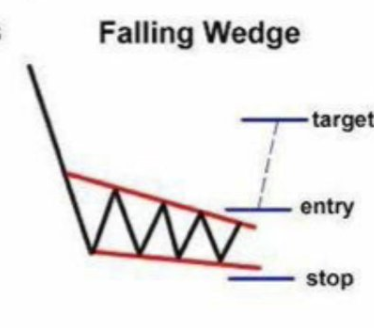

In [450]:
# trade if distance marker>50
distance_marker = 0
threshold = 90 # thersold step number to decide if the pattern forms 
initial_cash = 1e6
available_cash = initial_cash
order = 0
holding_marker = 0  # 1 for holding

for i in range(1, len(step)):
    if holding_marker == 1: # holding stock
        if df['Price'][step[i]]>=target_price: # achieve target price, sell
            available_cash,order = sell(order,available_cash,df['Price'][step[i]])
            holding_marker = 0
        elif df['Price'][step[i]]<=stop_loss: # drop below stop loss, sell
            available_cash,order = sell(order,available_cash,df['Price'][step[i]])
            holding_marker = 0
            
    # if the two lines both keep converging and move down
    if (high_gradient_list[i] < 0) and (low_gradient_list[i] < 0) and (low_gradient_list[i] == low_gradient_list[i-1]) and (high_gradient_list[i] == high_gradient_list[i-1]) and abs(high_gradient_list[i]) > abs(low_gradient_list[i]):
        # effective distance increase by 1
        distance_marker += 1
    else:
        # reset if the condition is not statisfied
        distance_marker = 0
    
    # effective distance greater than threshold, the pattern is considered to form
    if distance_marker > threshold:
        # place buying order
        buying_price = df['Price'][step[i]]
        # setting target price and stop loss
        target_price = 1.5*buying_price  # can modify the ratio here
        stop_loss = 0.9*buying_price
        available_cash, order = buy(order, available_cash, buying_price)
        distance_marker = 0 # reset effective distance
        holding_marker = 1 # holdiing the stock
        
        
# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:-110041.560000
Profit rate: -11.000000%


### 5.2 Rising Wedge

when the asset price is moving in an overall bullish trend and two converging trends line could be drawn to enclose the K lines. The price is likely to drop.

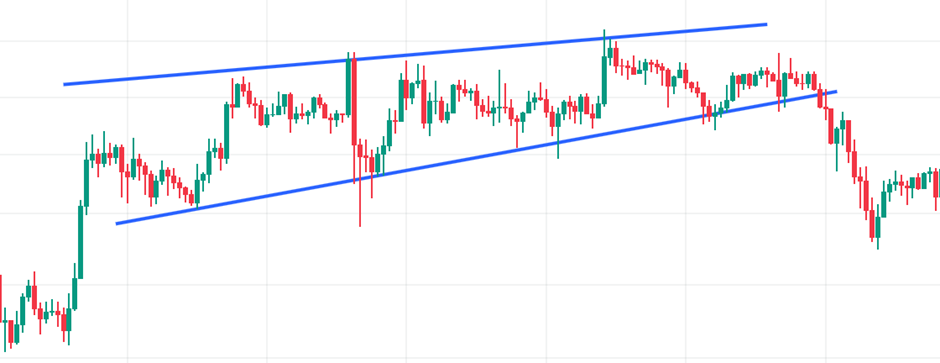

In [179]:
# trade if distance marker>50
distance_marker = 0
threshold = 90 # thersold step number to decide if the pattern forms 
initial_cash = 1e6
available_cash = initial_cash
order = 0
holding_marker = 0  # 1 for holding


# assume all-in at the beginning, as the rising wedge is a selling signal
available_cash,order = buy(order,available_cash,df['Price'][step[0]])
buying_price = df['Price'][step[0]]
target_price = 0.67*buying_price  # can modify the ratio here

for i in range(1, len(step)):
    if holding_marker == 0 and df['Price'][step[i]]<target_price: # drop below the target price, buy back
        available_cash,order = buy(order,available_cash,df['Price'][step[i]])
        holding_marker = 1 # holding stock
        buying_price = df['Price'][step[i]]
        target_price = 0.67*buying_price # set new target price
      
    # if the two lines both keep converging and move up
    if (high_gradient_list[i] > 0) and (low_gradient_list[i] > 0) and (low_gradient_list[i] == low_gradient_list[i-1]) and (high_gradient_list[i] == high_gradient_list[i-1]) and abs(high_gradient_list[i]) < abs(low_gradient_list[i]):
        # effective distance increase by 1
        distance_marker += 1
    else:
        # reset if the condition is not statisfied
        distance_marker = 0
        
    # effective distance greater than threshold, the pattern is considered to form
    if distance_marker > threshold and holding_marker == 1:
        # place selling order
        selling_price = df['Price'][step[i]]
        target_price = 0.67*selling_price  # modify the ratio
        available_cash, order = sell(order, available_cash, buying_price)
        distance_marker = 0 # reset effective distance
        holding_marker = 0 # not holdiing the stock
        
        
# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:476672.900000
Profit rate: 47.670000%


### 5.3 Head and Shoulders

This appears when three peaks occur, the outside two are close in height and the middle one is the highest. This signal would indicate a potential price drop. 

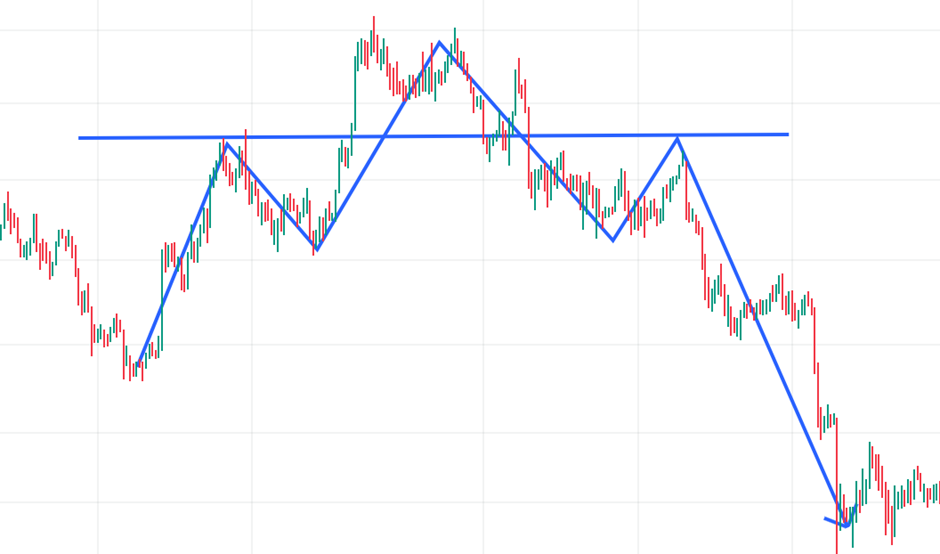

In [480]:
# trade if distance marker>50
distance_marker = 0
threshold = 90  # thersold step number to decide if the pattern forms
initial_cash = 1e6
available_cash = initial_cash
order = 0
holding_marker = 0  # 1 for holding


gradient_list = []
# this tolerance set to keep the two shoulder points have almost the same heights
gradient_diff_tol = 0.1
# assume all-in at the beginning, as the rising wedge is a selling signal
available_cash, order = buy(order, available_cash, df['Price'][step[0]])
selling_price = df['Price'][step[0]]
target_price = 1.5*buying_price  # modify the ratio
stop_loss = 0.9*buying_price


for i in range(1, len(step)):

    if holding_marker == 1:
        if df['Price'][step[i]] >= target_price:  # achieve target price, sell
            available_cash, order = sell(
                order, available_cash, df['Price'][step[i]])
            holding_marker = 0
        elif df['Price'][step[i]] <= stop_loss:  # drop below stop loss, sell
            available_cash, order = sell(
                order, available_cash, df['Price'][step[i]])
            holding_marker = 0

    # for upper line, if the gradient change, gradient list append new gradient
    if high_gradient_list[i] != high_gradient_list[i-1]:
        gradient_list.append(high_gradient_list[i])

    # if gradient change
    if len(gradient_list) >= 4 and (high_gradient_list[i] != high_gradient_list[i-1]):
        # if the head formed
        if (gradient_list[-4] > 0) and (gradient_list[-3] < 0):
            # if the two shoulders have roughly the same heights
            if abs(abs(gradient_list[-2])-abs(gradient_list[-5])) < gradient_diff_tol:
                # place a selling order
                selling_price = df['Price'][step[i]]
                target_price = 0.67*selling_price  # modify the ratio
                available_cash, order = sell(
                    order, available_cash, buying_price)
                distance_marker = 0
                holding_marker = 0

# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:51877.650000
Profit rate: 5.190000%


### 5.4 Inverse Head and Shoulders

a local minimum smaller than the adjacent two local minimum. The two adjacent points are also required to be at the same price level as well. This time the signal would indicate a bullish trend therefore the buying order would be placed at the right shoulder.

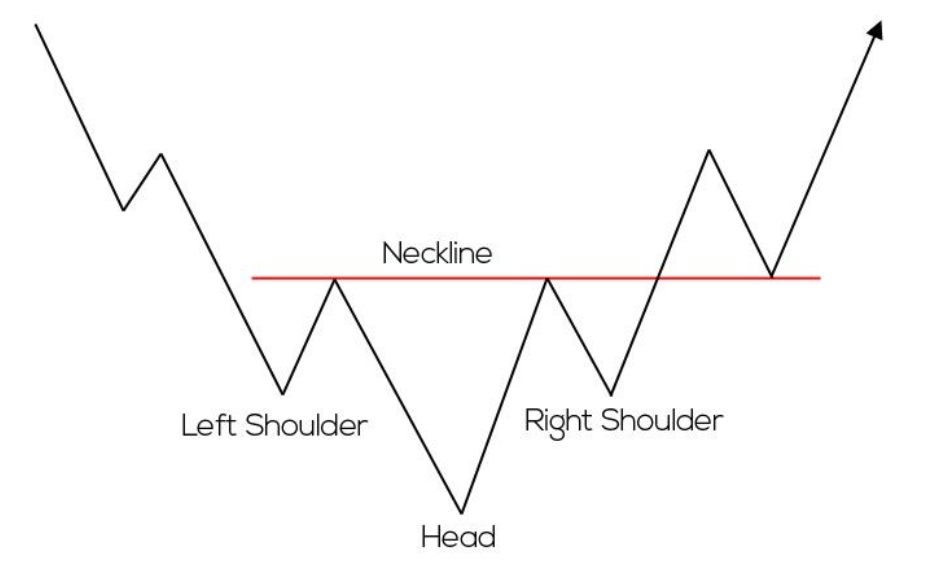

In [479]:
# trade if distance marker>50
distance_marker = 0
threshold = 90 # thersold step number to decide if the pattern forms 
initial_cash = 1e6
available_cash = initial_cash
order = 0
holding_marker = 0  # 1 for holding

gradient_list = []
gradient_diff_tol = 0.1 # this tolerance set to keep the two shoulder points have almost the same heights


for i in range(1, len(step)):
    
    if holding_marker == 1:
        if df['Price'][step[i]]>=target_price: # achieve target price, sell
            available_cash,order = sell(order,available_cash,df['Price'][step[i]])
            holding_marker = 0
        elif df['Price'][step[i]]<=stop_loss: # drop below stop loss, sell
            available_cash,order = sell(order,available_cash,df['Price'][step[i]])
            holding_marker = 0
    
    # for lower line, if the gradient change, gradient list append new gradient
    if low_gradient_list[i]!=low_gradient_list[i-1]: 
        gradient_list.append(low_gradient_list[i])    
    
    # if gradient change
    if len(gradient_list)>=5 and (low_gradient_list[i]!=low_gradient_list[i-1]):
        # if the trough formed
        if (gradient_list[-4]<0) and (gradient_list[-3]>0):
            #if the two shoulders have roughly the same heights
            if abs(abs(gradient_list[-2])-abs(gradient_list[-5]))<gradient_diff_tol:
                # place a buying order
                buying_price = df['Price'][step[i]]
                target_price = 1.2*buying_price  # modify the ratio
                stop_loss = 0.9*buying_price
                available_cash, order = buy(order, available_cash, buying_price)
                distance_marker = 0
                holding_marker = 1

# calculate the revenue and profit rate
revenue = available_cash+order*df['Price'][i]-initial_cash
revenue_rate = revenue/initial_cash

print('Revenue:%f' % revenue)
print('Profit rate: %f' % (round((revenue_rate*100), 2))+'%')

Revenue:124512.650000
Profit rate: 12.450000%
